# Transfer learning in text classification
Jen Seale, CUNY Graduate Center, Spring 2019<br>
jseale@gradcenter.cuny.edu

#### Abstract

## I. Introduction


The rest of this paper is as follows: Section II provides an overview of recent, related research. Section III reviews the experiment design of this research. Section IV describes the original dataset being used, and the modifications made to it. Section V contains the research experiment and its results. Section VI provides a discussion of the results and outlines future work. 

## II. Literature review
The multilabel genre prediction task provided by [the MM-IMDB dataset](http://lisi1.unal.edu.co/mmimdb/), and used in this research, has been used by Arevalo et al. (2017), and Kiela et al. (2018). The dataset provides poster images, plot summary text, metadata, and human-labeled genres for 25,959 movies for use in genre prediction. 

Kiela et al. (2018) provides accuracy scores for a number of different models on the MM-IMDB task, and come to conclude that multimodal models always outperform unimodal models on the task. They record 63.0 for Arevelo et al.'s (2017) GMU (gated multimodal unit) model—a micro F-measure score (Weisen and HaKoen-Kerner (2018)—and 61.5 for the Arevalo team's AVG_Probs model. The accuracy for Kiela et al.'s (2018) FastText model (providing a baseline as a text-only unimodal model) is recorded at 58.8 ± 0.1, and for a fine-tuned ResNet (baseline for image-only unimodal model) is recorded at 49.3 ± 0.0. Accuracy for their continuous, non-descritized multimodal models goes from 61.0 ± 0.0 to 62.3 ± 0.2 (averaged over five runs), the latter produced by a bilinear-gated model. Their work provides the baseline for this study, in which a unimodal text classifier outperforms both the top performing multimodal models from Arevalo, and Kiela's research. 


Genre prediction on other, similar, text-only, IMDB datasets has been performed, all with accuracy results that are outperformed by the text classifier developed in this research. Hoang (2018) developed the following multilabel classifiers, reported here with their F-scores, over the plot summaries of 250,000 IMDB movies. Hoang's Multinomial Naive Bayes classifier, trained with CBOW features had an F-1 of 53.0, his XGBoost classifier, using word2vec features as inputs, 49.0, and a Multinomial Gated Recurrent Unit had a 56.0.  

## III. Experiment design
Howard and Ruder's (2018) ULMFiT method is used to fine-tune a pretrained language model, WT103 (Merity et al. 2017; 2018), on the Arevalo et al. (2017) MM-IMDB dataset text, which is then used to create a custom classifier trained on the text and corresponding genres.

## IV. Data
Text from the 25,959 movies in the MM-IMDB dataset made available by Arevelo et al. (2017) is used for this project. This section provides a description of the original dataset, the modifications made to the data for this research, and the resulting dataset.

From the .json file, the 'genres' field provides the human-applied movie genres, and the 'title' and 'plot' field provide the text. The .jpeg file provides the movie poster image data which will be fused with the text data in training an prediction of the genres. 

In [1]:
#Makes data paths
import os
import json

path = os.path.abspath('{}/../'.format('transfer_learning_text_classification.ipynb') )
data_path = '{}/data/mmimdb/dataset/'.format(path)
make_data_path = '{}/data/mmimdb/'.format(path)

An example of the human-applied genres, the title, and the text that comprises the plot summary, prior to any cleaning or tokenization is printed below.

In [2]:
#Prints example of movie data
with open('{}0399877.json'.format(data_path)) as json_data:
    data = json.load(json_data)
    print(data['genres'])
    print(data['title'])
    print(data['plot'])

['Documentary', 'Comedy', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi']
What the #$*! Do We (K)now!?
['"WHAT THE #$*! DO WE KNOW?!" is a radical departure from convention. It demands a freedom of view and greatness of thought so far unknown, indeed, not even dreamed of since Copernicus. It\'s a documentary. It\'s a story. It\'s mind-blowing special effects. This film plunges you into a world where quantum uncertainty is demonstrated - where neurological processes, and perceptual shifts are engaged and lived by its protagonist - where everything is alive, and reality is changed by every thought.', "Amanda, a divorced photographer, finds herself in a fantastic Alice-in-Wonderland experience when her daily, uninspired life literally begins to unravel, revealing the cellular, molecular and even quantum worlds which lie beneath. Guided by a Greek Chorus of leading scientists and mystics, she finds that if reality itself is not questionable, her notion of it certainly is. Stunning special effects

A csv file, with a row per movie, where the human-applied movie genres for each of the movies, and their corresponding title and plot text live, and was created from the files provided in the MM-IMDB dataset using make_data.py. 

This csv format is used by the fastai library to further prepare the data to finetune the wikitext103 language model with the language used in the MM-IMDB movie reviews, and then to train the movie genre classifier.

In [3]:
#Run this cell to view the csv-making functionality
import sys
sys.path.insert(0, make_data_path)
import make_data

??make_data.texts_csv

The first five rows of the csv are printed below. You can see the human-applied movie genres, the targets to be predicted, are space-separated in one column of the csv. While there can be multiple genres per film, one genre is also possible. For each movie, the title of the movie appears before the plot summary in the text column—the title and the plot are space separated.

In [4]:
import pandas as pd
texts_df = pd.read_csv(make_data_path+"text_labels.csv")
texts_df.head()

,text,tags,tag count,plot_word_count
0,He Knows You're Alone A reluctant bride to be ...,Horror Thriller,2,101
1,Link Student Jane jobs as an assistant for the...,Horror,1,95
2,The Blacksmith Buster clowns around in a black...,Comedy,1,53
3,"Take the Lead In New York, the polite dance in...",Drama Music,2,316
4,Ping-pongkingen Rille is coming of age in a Sw...,Drama,1,149


The csv, as seen below, contains 25,959 rows—one row for every movie in the dataset.

In [5]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25951 entries, 0 to 25950
Data columns (total 4 columns):
text               25951 non-null object
tags               25917 non-null object
tag count          25951 non-null int64
plot_word_count    25951 non-null int64
dtypes: int64(2), object(2)
memory usage: 811.0+ KB


### Data descriptive statistics and modifications
This section provides descriptive statistics on the original dataset, makes modifications to the original dataset to remove genres that are applied to the lower 25th percentile of movies, as well as duplicates. 

#### Genres
There are 27 movie genres in the dataset. They are as follows, along with counts of how many times they are applied to movies.

In [6]:
import glob
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

genres = []
genre_count = {}

sys.path.insert(0, data_path)
for file in glob.glob('{}*.json'.format(data_path)):
    data = json.load(open(file))
    [genres.append(genre) for genre in data['genres']]

counts = Counter(genres)

In [7]:
counts_df = pd.DataFrame.from_dict(list(dict(counts).items()))
counts_named_df = counts_df.rename(columns={0:'Genre',1: '# Movies'})
counts_ordered_df = counts_named_df.sort_values(by='# Movies')

In [8]:
counts_ordered_df

,Genre,# Movies
25,Reality-TV,1
22,Talk-Show,2
26,Adult,4
18,News,64
23,Film-Noir,338
3,Short,471
24,Sport,634
20,Western,705
12,Musical,841
17,Animation,997


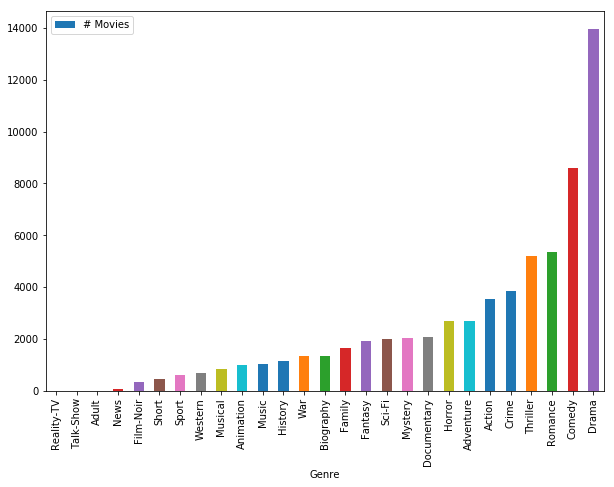

In [9]:
counts_ordered_df.plot(x='Genre', y='# Movies', kind='bar', figsize=(10,7))

Prior to removing genres in the lower 25th percentile from the dataset, in which outlier genres with as little as one representative movie exist, the dataset has a mean of 2,391 movies per genre over 27 genres, with a standard deviation from the mean of 3,039 movies. The median number of movies per genre is 1,343. See below for the descriptive statistics as generated by pandas _describe_ method.

In [10]:
counts_ordered_df['# Movies'].describe()

count       27.000000
mean      2391.481481
std       3039.278727
min          1.000000
25%        669.500000
50%       1343.000000
75%       2706.500000
max      13967.000000
Name: # Movies, dtype: float64

After removing genres in the lower 25th percentile, there are, on average, 3,152 movies per genre over 20 genres, with a standard deviation of 3,203. The median number of movies per genre is 2,024. 75th percentile and above genres are retained due to their importance in the general task of predicting movie genres. 

Below, the number of movies per genre within the new subset of 20 genres is confirmed.

In [11]:
lower_25th_percentile_genres_removed = counts_ordered_df[counts_ordered_df['# Movies'] > counts_ordered_df['# Movies'].quantile(.25)]

In [12]:
lower_25th_percentile_genres_removed

,Genre,# Movies
20,Western,705
12,Musical,841
17,Animation,997
5,Music,1045
9,History,1143
11,War,1335
21,Biography,1343
19,Family,1668
15,Fantasy,1933
16,Sci-Fi,1991


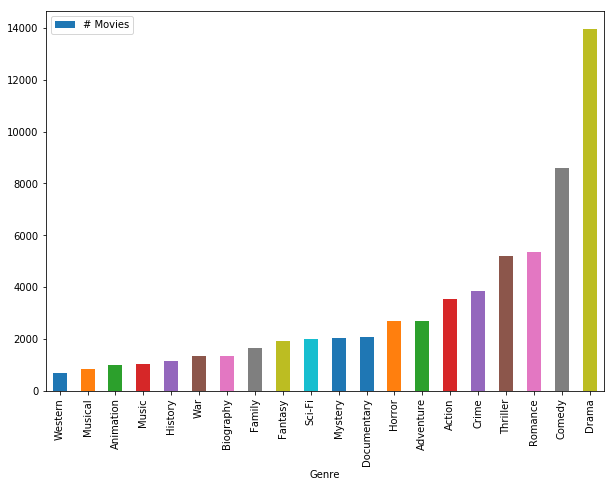

In [13]:
lower_25th_percentile_genres_removed.plot(x='Genre', y='# Movies', kind='bar', figsize=(10,7))

In [14]:
lower_25th_percentile_genres_removed['# Movies'].describe()

count       20.000000
mean      3152.800000
std       3203.948544
min        705.000000
25%       1287.000000
50%       2024.000000
75%       3622.000000
max      13967.000000
Name: # Movies, dtype: float64

#### Genres modification
Above it was determined what the dataset would look like with the lower 25th percentile genres removed. Below those genres are removed from the dataset.

In [15]:
genres_to_remove = ['Reality-TV', 
                    'Talk-Show', 
                    'Adult', 
                    'News', 
                    'Film-Noir', 
                    'Short', 
                    'Sport']

In [18]:
texts_lower_genres_rm_df = texts_df.dropna()

In [19]:
texts_lower_genres_rm_df['tags'] = texts_lower_genres_rm_df.tags.apply(lambda tags: 
                                                                       ' '.join([tag for tag in tags.split() 
                                                                                 if tag not in genres_to_remove]))

/home/ubuntu/anaconda3/envs/gmu_bimodal/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
texts_lower_genres_rm_df.head()

,text,tags,tag count,plot_word_count
0,He Knows You're Alone A reluctant bride to be ...,Horror Thriller,2,101
1,Link Student Jane jobs as an assistant for the...,Horror,1,95
2,The Blacksmith Buster clowns around in a black...,Comedy,1,53
3,"Take the Lead In New York, the polite dance in...",Drama Music,2,316
4,Ping-pongkingen Rille is coming of age in a Sw...,Drama,1,149


In [21]:
texts_lower_genres_rm_df.describe()

,tag count,plot_word_count
count,25917.000000,25917.000000
mean,2.432072,164.573523
std,1.176500,146.640064
min,1.000000,3.000000
25%,2.000000,66.000000
50%,2.000000,120.000000
75%,3.000000,216.000000
max,10.000000,1900.000000


As can be seen above, eight movie summary texts are not unique. Duplicates are removed below. 

In [22]:
texts_no_dups_df = texts_lower_genres_rm_df.drop_duplicates(subset='text')

In [23]:
texts_no_dups_df.head()

,text,tags,tag count,plot_word_count
0,He Knows You're Alone A reluctant bride to be ...,Horror Thriller,2,101
1,Link Student Jane jobs as an assistant for the...,Horror,1,95
2,The Blacksmith Buster clowns around in a black...,Comedy,1,53
3,"Take the Lead In New York, the polite dance in...",Drama Music,2,316
4,Ping-pongkingen Rille is coming of age in a Sw...,Drama,1,149


In [24]:
texts_no_dups_df.describe()

,tag count,plot_word_count
count,25917.000000,25917.000000
mean,2.432072,164.573523
std,1.176500,146.640064
min,1.000000,3.000000
25%,2.000000,66.000000
50%,2.000000,120.000000
75%,3.000000,216.000000
max,10.000000,1900.000000


In [25]:
texts_tag_counts = texts_no_dups_df
texts_tag_counts.loc[:, 'tag_count'] = texts_tag_counts.tags.apply(
                                        lambda x: len(x.split(' ')))

In [30]:
texts_tag_counts.describe()

,tag count,plot_word_count,tag_count
count,25917.000000,25917.000000,25917.000000
mean,2.432072,164.573523,2.432072
std,1.176500,146.640064,1.176500
min,1.000000,3.000000,1.000000
25%,2.000000,66.000000,2.000000
50%,2.000000,120.000000,2.000000
75%,3.000000,216.000000,3.000000
max,10.000000,1900.000000,10.000000


### Text descriptive statistics
Im the modified dataset with 20 movie genres, and movies with duplicate text summaries removed, 25,917 movies are represented. On the average each movie plot summary as 164 words, with a standard deviation of 146 words from the mean. The median number of words in a movie plot summary is 120. The smallest number of words in a movie plot summary is 3 words, while the largest is 1900 words. The title is always included in the summary at the beginning of the summary.

In [31]:
texts_tag_word_counts = texts_tag_counts
texts_tag_word_counts.loc[:, 'plot_word_count'] = texts_tag_counts.text.apply(
                                        lambda x: len(x.split(' ')))

In [32]:
texts_tag_word_counts['plot_word_count'].describe()

count    25917.000000
mean       164.573523
std        146.640064
min          3.000000
25%         66.000000
50%        120.000000
75%        216.000000
max       1900.000000
Name: plot_word_count, dtype: float64

In [33]:
texts_tag_word_counts.head()

,text,tags,tag count,plot_word_count,tag_count
0,He Knows You're Alone A reluctant bride to be ...,Horror Thriller,2,101,2
1,Link Student Jane jobs as an assistant for the...,Horror,1,95,1
2,The Blacksmith Buster clowns around in a black...,Comedy,1,53,1
3,"Take the Lead In New York, the polite dance in...",Drama Music,2,316,2
4,Ping-pongkingen Rille is coming of age in a Sw...,Drama,1,149,1


### Data summary

Eight movie summaries were removed from the original dataset with 25,959 movies due to text summary duplication. There are 25,951 genre-labeled movie summaries in the final, modified dataset. On average there are ~2 human-labeled genres per movie, and each movie summary (which includes the movie title) has ~164 words. 

Seven genres were removed from the original dataset with 27 movie genres due to the genres' application to movies in the lower 25th percentile of tagged movies. There are 20 genres in the final dataset. On average, there are 3,152 movies per genre. _Drama_, _Comedy_, and _Romance_ are the top-most labeled genres, while _Animation_, _Musical_ and _Western_ are used the least.

Further work will be done on the data (e.g., tokenization, numericalization) to prepare it for the language model and subsequently developed text classifier, and is covered in depth in section V. 

In [34]:
texts_tag_word_counts.to_csv("{}text_mod_labels.csv".format(make_data_path),index=False)

## V. Experiment

### Language model


###### Libraries
The model is built using the PyTorch 1.0.0 (Paszke et al. 2017) and fastai 1.0.40 (Howard et al. 2018) libraries. 

In [46]:
import torch
import fastai
from fastai.text import * 

###### Hardware
The model is trained on an AWS EC2 p2.xlarge persistent spot instance, using one GPU. 

In [47]:
#USE GPU - Device 0 
torch.cuda.set_device(0)

#### Loading the data
The fastai TextLMDataBunch function does the following: [TO DO: FILL THIS OUT]


In [48]:
# Language model data
#https://docs.fast.ai/text.html
data_lm = TextLMDataBunch.from_csv(make_data_path, 'text_mod_labels.csv', text_cols = 'text')
data_lm.save()
data_lm = TextLMDataBunch.load(make_data_path)

##### WT103

In [49]:
# Language model creation with WT103
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,4.255065,3.911136,0.316711


##### Fine-tune language model with MM-IMDB title and summary text

In [50]:
# Unfreeze final layer and fine-tune to MM-IMDB data (data_lm)
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,3.850173,3.760491,0.333352


In [56]:
print(learn.model)

SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(36989, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(36989, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1)
  

##### _An example of the language model's predictive capacity_

In [51]:
learn.predict("This movie really", n_words=15)

"This movie really is copper and it 's not so easy to make a fortune out of this"

In [52]:
#Save the language model
learn.save_encoder('lm_encoder')

### Text classifier 

In [53]:
#Split data into train and validate sets
from sklearn.model_selection import train_test_split
texts_df = pd.read_csv(make_data_path+'text_mod_labels.csv')
train, valid = train_test_split(texts_df, test_size = 0.02, random_state = 0)

In [54]:
# Classifier model data
data_multilabel = TextClasDataBunch.from_df(path, 
                                      train_df = train,
                                      valid_df = valid,
                                      text_cols = 'text', 
                                      label_cols ='tags',
                                      label_delim=' ', 
                                      vocab=data_lm.train_ds.vocab, 
                                      bs=32)
data_multilabel.save()
data_multilabel = TextClasDataBunch.load(path, bs=32)

In [58]:
#Classifier model creation
learn = text_classifier_learner(data_multilabel, drop_mult=0.5, metrics = [accuracy_thresh, fbeta])
print("learn classifier defined. model summary:")
print(learn.model)
learn.load_encoder('{}/models/lm_encoder'.format(make_data_path))

learn classifier defined. model summary:
SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(36989, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(36989, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running

In [59]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.235395,0.209842,0.909827,0.716080


In [60]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.228122,0.288602,0.916474,0.722511


In [61]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.218836,0.434601,0.916185,0.729329


#### Text classifier metrics
As the classification problem we are facing is a multilabel problem, where each text can have multiple genres, it affects model design and metrics. The model is discussed in the Language Model section and the metrics, here. Performance is scored on two fastai metrics, accuracy_thresh and fbeta.

##### accuracy_thresh
accuracy_thresh could be considered, the 'accuracy of the model's predictions above a certain threshold', and is computed only when the number of predictions our model makes matches the number of human-applied labels provided in the MM-IMDB dataset.

The language classifier model uses a final sigmoid activation function [TO DO: ISOLATE THE SIGMOID FUNCTION IN THE RNN CODE] outputing a confidence score for any of the 26 possible genre labels [TO DO: DETERMINE WHY THE BIAS IS INCLUDED IN THE FINAL RNN LAYER] between 0 and 1—and our model is set to consider anything above a .5 threshold as a match between the predicted and actual labels. Again, for each movie, the accuracy_thresh measure only when the number of predicted labels matches the number of applied labels. The average of the accuracy_thresh scores is then computed for the entirety of training dataset and recorded per training epoch. The accuracy_thresh obtained during the final training epoch for the experiment conducted on January 21, 2019 is 93.4.

##### fbeta
fbeta is the F1 (accuracy) score computed using the weighted harmonic mean of the model's precision and recall. This is the score compared, in this research, to Arevalo et al, and Kiela et al.s' gated multimodal unit accuracy scores recorded in Kiela et al. (2018) on the same task, with the same data. [TO DO: Find and outline their accuracy metrics.]

In the fbeta/F1 score, the beta parameter acts as a weight that promotes either precision or recall in the combined score. A beta over 1 promotes recall, under 1 promotes precision, at 0 considers only precision and as it reaches infinity considers only recall. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html)

The beta parameter used in the model's fbeta is 2, meaning the metric favors recall slightly over precision.

_Recall_ is defined as the number of true positives over the number of true postives plus false negatives. What does that mean? It means that you're measuring the percent you got right out of all that you should have gotten right. _Precision_ is defined as the number of true positives over the number of true positives plus false positives. What does that mean? It means you're measuring the percent of all the predictions you got right out of the ones you made. _Recall_ can therefore be considered a more stringent metric, and the model's beta parameter favoring recall slightly means that the measurement is a bit stricter than if it favored, or only took into consideration, precision.

The fbeta obtained during the final training epoch for the experiment conducted on January 21, 2019 is 71.0. This means that by employing Howard and Ruder's (2018) ULMFiT method on the WT103_1 English language model (Merity et al. 2017, Howard and Ruder 2018) with the MM-IMDB title and plot summary data, and genre classifications (Arevelo et al. 2017), we already see higher accuracy performance than the fusion models previously employed on the same classification task and data; and the fusion models were outperforming text-only models (Kiela et al. 2018).

### References
Arevalo, John, Thamar Solorio, Manuel Montes-y Gomez, and Fabio A Gonzalez. 2017. Gated multimodal units for information fusion. arXiv preprint arXiv:1702.01992.

Barsalou, Lawrence W. 2008. Grounded cognition. Annu. Rev. Psychol. 59: 617–645.

Cao, Chunshui, Xianming Liu, Yi Yang, Yinan Yu, Jiang Wang, Zilei Wang, Yongzhen Huang, Liang Wang, Chang Huang, Wei Xu, et al.. 2015. Look and think twice: Capturing top-down visual attention with feedback convolutional neural networks. In Proceedings of the ieee international conference on computer vision, 2956–2964.

Glenberg, Arthur M, and Michael P Kaschak. 2002. Grounding language in action. Psychonomic Bulletin & Review 9 (3): 558–565.

Hill, Felix, and Anna Korhonen. 2014. Learning abstract concept embeddings from multi-modal data: Since you probably can’t see what I mean. In Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), 255–265.

Hoang, Q. 2018. Predicting Movie Genres Based on Plot Summaries. arXiv preprint arXiv:1801.04813.

Howard, Jeremy, and Sebastian Ruder. 2018. Fine-tuned language models for text classification. arXiv preprint arXiv:1801.06146.

Howard, Jeremy, and others. 2018. fastai. GitHub. https://github.com/fastai/fastai.

Kiela, Douwe, Edouard Grave, Armand Joulin, and Tomas Mikolov. 2018. Efficient large-scale multi-modal classification. arXiv preprint arXiv:1802.02892.

Lazaridou, Angeliki, Nghia The Pham, and Marco Baroni. 2015. Combining language and vision with a multimodal skip-gram model. arXiv preprint arXiv:1501.02598.

Merity, S., Xiong, C., Bradbury, J., and Socher, R. Pointer. 2017. Sentinel Mixture Models. International Conference on Learning Representations.

Merity, S., Keskar, N. S., & Socher, R. 2018. An Analysis of Neural Language Modeling at Multiple Scales. arXiv preprint arXiv:1803.08240.

Paszke, Adam and Gross, Sam and Chintala, Soumith and Chanan, Gregory and Yang, Edward and DeVito, Zachary and Lin, Zeming and Desmaison, Alban and Antiga, Luca and Lerer, Adam. 2017. Automatic differentiation in PyTorch.

Ronneberger, O., Fischer, P., & Brox, T. 2015. U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

Smith, Leslie N. 2017. Cyclical learning rates for training neural networks. In Applications of computer vision (wacv), 2017 ieee winter conference on, 464–472. IEEE. IEEE.

Stanford University. n.d. Module 04: Neural Networks: Representation, Non-linear hypotheses. In Machine Learning [recorded lecture by Andrew Ng]. Retrieved from https://www.coursera.org/learn/machine-learning/home/week/4.

Torrey, Lisa, and Jude Shavlik. 2009. Transfer learning. Handbook of Research on Machine Learning Applications and Trends: Algorithms, Methods, and Techniques 1: 242.

Weisen, Aryeh, and HaCohen-Kerner, Yaakov. 2018. Overview of Uni-modal and Multi-Modal Representations for Classification Tasks. In International Conference on Applications of Natural Language to Information Systems (pp. 397-404). Springer, Cham.

Young, T., Hazarika, D., Poria, S., & Cambria, E. 2018. Recent trends in deep learning based natural language processing. ieee Computational intelligenCe magazine, 13(3), 55-75.

Zablocki, Eloi, Benjamin Piwowarski, Laure Soulier, and Patrick Gallinari. 2017. Learning multi-modal word representation grounded in visual context. arXiv preprint arXiv:1711.03483.

Zheng, Heliang, Jianlong Fu, Tao Mei, and Jiebo Luo. 2017. Learning multi-attention convolutional neural network for fine-grained image recognition. In Int. conf. on computer vision.